<a href="https://colab.research.google.com/github/marquesarthur/vanilla-bert-vs-huggingface/blob/main/hugging_face_keras_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on 



1.   https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379
2.   https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/
3.   https://huggingface.co/transformers/training.html#fine-tuning-with-keras




**problem statement:**


*   a developer has to inspect an **artifact X**
*   Within the artifact, only a portion of the text is relevant to **input task Y**
*   We ought to build a model that establishes relationships between **Y** and **sentences x ∈ X** 
*  The model must determine: **is x relevant to task Y**




<br>

___

*Example of a task and an annotated artifact:*

<br>

[<img src="https://i.imgur.com/Zj1317H.jpg">](https://i.imgur.com/Zj1317H.jpg)




* The coloured sentences are sentences annotated as relevant to the input task. 
* The warmer the color, the more annotators selected that portion of the text. 
* For simplicity, we process the data and used sentences 

<br>

___

*Ultimately, our data is a tuple representing:*


*   **text** = artifact sentence

*   **question** = task description

*   **source** = URL of the artifact

*   **category_index** = whether sentence is relevant [or not] for the input task

*   **weights** = number of participants who annotated sentence as relevant


<br>

___



In [1]:
# @title Install dependencies

# !pip install transformers
# %tensorflow_version 2.x

In [2]:
# !pip install -q scikit-learn tqdm pandas python-Levenshtein path colorama

In [3]:
# @title Download git repo
# !git clone https://github.com/marquesarthur/vanilla-bert-vs-huggingface.git

In [4]:
# %cd vanilla-bert-vs-huggingface
# !git pull
# !ls -l

In [5]:
# @title Import data as JSON
import itertools
import json
import logging
import os
import sys
import random
from pathlib import Path

from Levenshtein import ratio
from colorama import Fore, Style

logger = logging.getLogger()
logger.level = logging.DEBUG
stream_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stream_handler)

from ds_android import get_input_for_BERT

raw_data = get_input_for_BERT()

print('Sample entry from data:')
print(json.dumps(raw_data[0], indent=4, sort_keys=True))

5 47  https://developer.android.com/reference/android/widget/ArrayAdapter
9 21  https://stackoverflow.com/questions/6442054
3 22  https://github.com/nostra13/Android-Universal-Image-Loader/issues/462
22 211  https://www.raywenderlich.com/155-android-listview-tutorial-with-kotlin
21 59  https://guides.codepath.com/android/Using-an-ArrayAdapter-with-ListView
6 33  https://github.com/realm/realm-java/issues/776
9 15  https://developer.android.com/training/volley/request
14 65  https://stackoverflow.com/questions/28504524
20 59  https://medium.com/@JasonCromer/android-asynctask-http-request-tutorial-6b429d833e28
5 97  https://www.twilio.com/blog/5-ways-to-make-http-requests-in-java
17 33  https://developer.android.com/guide/navigation/navigation-custom-back
6 55  https://stackoverflow.com/questions/10108774
5 470  https://developer.android.com/reference/android/widget/TextView
7 11  https://stackoverflow.com/questions/19025301
3 17  https://stackoverflow.com/questions/8712652
8 59  https:/

5 57  https://github.com/signalapp/Signal-Android/issues/3376
22 104  https://developer.android.com/reference/org/json/JSONObject
8 31  https://guides.codepath.com/android/converting-json-to-models
5 34  https://developer.android.com/guide/topics/media-apps/volume-and-earphones
4 40  https://developer.android.com/training/gestures/scale
6 32  https://stackoverflow.com/questions/10630373
Sample entry from data:
{
    "category_index": 0,
    "question": "Explanation of the getView() method of an ArrayAdapter",
    "source": "https://developer.android.com/reference/android/widget/ArrayAdapter",
    "text": "public class ArrayAdapter extends BaseAdapter implements Filterable, ThemedSpinnerAdapter",
    "weights": 0
}


In [6]:
from collections import Counter, defaultdict

cnt = Counter([d['category_index'] for d in raw_data])

total = sum(cnt.values())

labels_cnt = [cnt[0] / float(total), cnt[1] / float(total)]
print('label distribution')
print('')
print('not-relevant -- {:.0f}%'.format(labels_cnt[0] * 100))
print('RELEVANT ------ {:.0f}%'.format(labels_cnt[1] * 100))

label distribution

not-relevant -- 88%
RELEVANT ------ 12%


In [7]:
seframes = {}
with open('seframes.json') as input_file:
    seframes = json.load(input_file)

In [8]:
def has_meaningful_frame(text):    
    meaning_frames = [
        'Temporal_collocation', 'Execution', 'Using', 'Intentionally_act',
        'Being_obligated', 'Likelihood', 'Causation', 'Required_event',
        'Desiring', 'Awareness', 'Grasp', 'Attempt'
    ]
    
    if text in seframes:
        text_labels = seframes[text]
        if any([elem in meaning_frames for elem in text_labels]):
            return True
        
    return False

In [9]:
# @title Set environment variables

model_id = 'bert-base-uncased'
# model_id = 'distilbert-base-uncased'

import os
import contextlib
import tensorflow as tf
import os
import codecs
import numpy as np
import math
import json

import numpy as np
import pandas as pd

from collections import defaultdict, Counter
from tqdm import tqdm

USE_TPU = False
os.environ['TF_KERAS'] = '1'

# @title Initialize TPU Strategy
if USE_TPU:
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
    tf.contrib.distribute.initialize_tpu_system(resolver)
    strategy = tf.contrib.distribute.TPUStrategy(resolver)

# sklearn libs
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

# Tensorflow Imports
import tensorflow as tf
from tensorflow.python import keras
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers


# Hugging face imports
from transformers import AutoTokenizer
from transformers import TFDistilBertForSequenceClassification, TFBertForSequenceClassification
from transformers import TFDistilBertModel, DistilBertConfig
from transformers import DistilBertTokenizerFast, BertTokenizerFast



# Bert Model Constants
SEQ_LEN = 64 # 128
BATCH_SIZE = 64 # 64 32 larger batch size causes OOM errors
EPOCHS = 10 # 3 4
LR = 1e-5 # 3e-5

# 3e-4, 1e-4, 5e-5, 3e-5
# My own constants
# USE_FRAME_FILTERING = False
# UNDERSAMPLING = True
# N_UNDERSAMPLING = 2 # ratio of how many samples from 0-class, to 1-class, e.g.: 2:1
# USE_DS_SYNTHETIC = False


USE_FRAME_FILTERING = False
UNDERSAMPLING = True
N_UNDERSAMPLING = 2 # ratio of how many samples from 0-class, to 1-class, e.g.: 2:1
USE_DS_SYNTHETIC = False
MIN_W = 3 # 1 = all highlights, 2 = all highlights selected by 2 participants, etc

Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


In [10]:
# @title JSON to dataframe helper functions
def undersample_df(df, n_times=3):
    class_0,class_1 = df.category_index.value_counts()
    c0 = df[df['category_index'] == 0]
    c1 = df[df['category_index'] == 1]
    df_0 = c0.sample(int(n_times * class_1))
    
    undersampled_df = pd.concat([df_0, c1],axis=0)
    return undersampled_df

def get_ds_synthetic_data(min_w=2, undersample_n=3):
    short_task = {
      "bugzilla": """How to query bugs using the custom fields with the Bugzilla REST API?""",
      "databases": """Which technology should be adopted for the database layer abstraction: Object/Relational Mapping (ORM) or a Java Database Connectivity API (JDBC)?""",
      "gpmdpu": """Can I bind the cmd key to the GPMDPU shortcuts?""",
      "lucene": """How does Lucene compute similarity scores for the BM25 similarity?""",
      "networking": """Which technology should be adopted for the notification system, Server-Sent Events (SSE) or WebSockets?""",
    }

    with open('relevance_corpus.json') as ipf:
        aux = json.load(ipf)
        raw_data = defaultdict(list)
        for d in aux:
            if d['task'] == 'yargs':
                continue

            raw_data['text'].append(d['text'])
            raw_data['question'].append(short_task[d['task']])
            raw_data['source'].append(d['source'])
            raw_data['category_index'].append(1 if d['weight'] > min_w else 0)
            raw_data['weights'].append(d['weight'] if d['weight'] > min_w else 0)
 
        data = pd.DataFrame.from_dict(raw_data)
        data = undersample_df(data, n_times=undersample_n)
        data = data.sample(frac=1).reset_index(drop=True)
      
    return data

def get_class_weights(y, smooth_factor=0, upper_bound=5.0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    clazz = {cls: float(majority / count) for cls, count in counter.items()}
    result = {}
    for key, value in clazz.items():
        if value > upper_bound:
            value = upper_bound
        
        result[key] = value
    return result

def add_raw_data(result, data):
    result['text'].append(data['text'])
    result['question'].append(data['question'])
    result['source'].append(data['source'])
    result['category_index'].append(data['category_index'])
    result['weights'].append(data['weights'])


In [11]:
# @title Tokenizer

print(model_id)
if model_id == 'distilbert-base-uncased':
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_id)
else:
    tokenizer = BertTokenizerFast.from_pretrained(model_id)

bert-base-uncased
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 0
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer.json HTTP/1.1" 200 0
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/added_tokens.json HTTP/1.1" 404 0
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/special_tokens_map.json HTTP/1.1" 404 0
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


In [12]:
# @title data encoder

def _encode(tokenizer, dataframe, max_length=SEQ_LEN):
    
    seq_a = dataframe['text'].tolist()
    seq_b = dataframe['question'].tolist()
    
    return tokenizer(seq_a, seq_b, truncation=True, padding=True, max_length=max_length)

def to_one_hot_encoding(data, nb_classes = 2):
    targets = np.array([data]).reshape(-1)
    one_hot_targets = np.eye(nb_classes)[targets]
    return one_hot_targets    

In [13]:
# @title Metrics & Logging functions

from sklearn.metrics import classification_report

recommendation_metrics = defaultdict(list)
prediction_metrics = defaultdict(list)
clz_report_lst = defaultdict(list)
random_prediction_metrics = defaultdict(list)

classification_report_lst = []
log_examples_lst = []
source_lst = []

def aggregate_macro_metrics(store_at, precision, recall, fscore):   
    store_at['precision'].append(precision)
    store_at['recall'].append(recall)
    store_at['fscore'].append(fscore)

def aggregate_recommendation_metrics(store_at, k, precision_at_k, pyramid_precision_at_k):
    store_at['k'].append(k)
    store_at['precision'].append(precision_at_k)
    store_at['∆ precision'].append(pyramid_precision_at_k)
    
def aggregate_report_metrics(clz_report):
    relevant_label = str(1)
    if relevant_label in clz_report:
        for _key in ['precision', 'recall']:
            if _key in clz_report[relevant_label]:
                clz_report_lst[_key].append(clz_report[relevant_label][_key])    

def log_examples(task_title, source, text, pweights, y_predict, y_probs, k=10):
    # get the predicted prob at every index
    idx_probs = [(idx, y_predict[idx], y_probs[idx]) for idx, _ in enumerate(y_predict)]
    
    # filter probs for all indexes predicted as relevant  
    idx_probs = list(filter(lambda k: k[1] == 1, idx_probs))
    
    most_probable = sorted(idx_probs, key=lambda i: i[2], reverse=True)
    
    result = [idx for idx, _, _ in most_probable][:k]
    
    for idx in result:
        log_examples_lst.append((
            source, 
            task_title,
            pweights[idx],
            y_predict[idx],
            y_probs[idx],
            text[idx]
        ))

def _precision_at_k(y_test, y_predict, y_prob, k=10):
    # get the predicted prob at every index
    idx_probs = [(idx, y_predict[idx], y_prob[idx]) for idx, _ in enumerate(y_test)]
    
    # filter probs for all indexes predicted as relevant  
    idx_probs = list(filter(lambda k: k[1] == 1, idx_probs))
    
    most_probable = sorted(idx_probs, key=lambda i: i[2], reverse=True)
    result = [y_test[idx] * y_predict[idx] for idx, _, _ in most_probable]   
    y_predict = [y for _, y, _ in most_probable]
    
    result = result[:k]
    y_predict = y_predict[:k]
    ratio = sum(result) / float(len(y_predict) + 0.00001)
    return ratio     


def _pyramid_score(y_optimal, y_predicted, y_prob, k=10):

    # create reference table for weights 
    # y_predicted = [i for i in y_optimal]
    # get the predicted prob at every index
    idx_probs = [(idx, y_optimal[idx], y_predicted[idx], y_prob[idx]) for idx, _ in enumerate(y_optimal)]
    
    # filter probs for all indexes predicted as relevant  
    idx_probs = list(filter(lambda aux: aux[2] == 1, idx_probs))

    # sort
    most_probable = sorted(idx_probs, key=lambda i: i[3], reverse=True)

    # compute predicted and optimal score up until K
    predicted_score = [w for _, w, _, _ in most_probable][:k]
    optimal_score = sorted(y_optimal, reverse=True)[:k]
    
    ratio = sum(predicted_score) / float(sum(optimal_score) + 0.00001)
    return ratio           

In [14]:
#@title Training procedures

def get_train_val_test(task_uid, size=0.9, undersample=False, aug=True, undersample_n=3, min_w=2):
    if not isinstance(task_uid, list):
        task_uid = [task_uid]
        
    train_data_raw = defaultdict(list)
    test_data_raw = defaultdict(list)
    
    for _data in tqdm(CORPUS):
        if _data['question'] in task_uid:
            add_raw_data(test_data_raw, _data)
        
    
    train_val = get_ds_synthetic_data(undersample_n=undersample_n, min_w=min_w)
    test = pd.DataFrame.from_dict(test_data_raw)
    
    # https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
    #  randomize rows....    
    train_val = train_val.sample(frac=1).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)
    
    print(train_val['category_index'].value_counts())
    
#     if undersample:
#         train_val = undersample_df(train_val, n_times=undersample_n)
#         train_val = train_val.sample(frac=1).reset_index(drop=True)
    
    weights = get_class_weights(train_val['category_index'].tolist())
    
    train, val = train_test_split(
        train_val, 
        stratify=train_val['category_index'].tolist(), 
        train_size=size
    )
    
    return train, val, test, weights        

In [15]:
def update_predictions(task_title, text, y_predict, y_probs, relevant_class=1):
    result = []
    
    for _t, _y, _prob in zip(text, y_predict, y_probs):
        if _y == relevant_class:
            if has_meaningful_frame(_t):
                result.append(_y)
            else:
                result.append(0)
        else:
            result.append(_y)
    
    return result    

In [16]:
# @title Testing procedures

# https://medium.com/geekculture/hugging-face-distilbert-tensorflow-for-custom-text-classification-1ad4a49e26a7
def eval_model(model, test_data):
    preds = model.predict(test_data.batch(1)).logits  
    
    #transform to array with probabilities
    res = tf.nn.softmax(preds, axis=1).numpy()      

    return res.argmax(axis=-1), res[:, 1]

def test_model(source, df_test, model, tokenizer, pos_filter=False):
    
    df_source = df_test[df_test["source"] == source]   
    task_title = df_source['question'].tolist()[0]
    text = df_source['text'].tolist()
    pweights = df_source['weights'].tolist()
    
    # Encode X_test
    test_encodings = _encode(tokenizer, df_source)
    test_labels = df_source['category_index'].tolist()
    
    test_dataset = tf.data.Dataset.from_tensor_slices((
        dict(test_encodings),
        test_labels
    ))
    
    y_true = [y.numpy() for x, y in test_dataset]
    y_predict, y_probs = eval_model(model, test_dataset)
    
    if pos_filter:
        y_predict = update_predictions(task_title, text, y_predict, y_probs)
    

    accuracy = accuracy_score(y_true, y_predict)
    macro_f1 = f1_score(y_true, y_predict, average='macro')
    
    classification_report_lst.append(classification_report(y_true, y_predict))
    aggregate_report_metrics(classification_report(y_true, y_predict, output_dict=True))

    logger.info("-" * 20)    
    
    logger.info("Y")
    logger.info("[0s] {} [1s] {}".format(
        len(list(filter(lambda k: k== 0, y_true))),
        len(list(filter(lambda k: k== 1, y_true)))
    ))
    
        
    logger.info("predicted")
    logger.info("[0s] {} [1s] {}".format(
        len(list(filter(lambda k: k== 0, y_predict))),
        len(list(filter(lambda k: k== 1, y_predict)))
    ))
    
    logger.info("-" * 20)
    
    logger.info("Accuracy: {:.4f}".format(accuracy))
    logger.info("macro_f1: {:.4f}".format(macro_f1))

    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict, average='macro')
    
    aggregate_macro_metrics(prediction_metrics, precision, recall, fscore)
    
    logger.info("Precision: {:.4f}".format(precision))
    logger.info("Recall: {:.4f}".format(recall))
    logger.info("F1: {:.4f}".format(fscore))
    
    logger.info("-" * 20)
    
    for k in [3, 5, 10]:
        p_at_k = _precision_at_k(y_true, y_predict, y_probs, k=k)
        score_at_k = 0.0 #_pyramid_score(pweights, y_predict, y_probs, k=k)
                                     
        aggregate_recommendation_metrics(recommendation_metrics, k, p_at_k, score_at_k)
        
        logger.info("")
        logger.info("Precision_at_{}: {:.4f}".format(k, p_at_k))
        logger.info("Pyramid_at_{}: {:.4f}".format(k, score_at_k))
    logger.info("-" * 20)
    
    log_examples(task_title, source, text, pweights, y_predict, y_probs, k=10)
    source_lst.append(source)
    
    # how do we compare against random guessing?
    random_predict = [np.random.randint(0,2) for _ in range(len(y_true))]
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, random_predict, average='macro')    
    aggregate_macro_metrics(random_prediction_metrics, precision, recall, fscore)

In [17]:
# @title 10-fold cross validation WIP
CORPUS = raw_data

all_tasks = sorted(list(set([d['question'] for d in raw_data])))
rseed = 20210343
random.seed(rseed)
random.shuffle(all_tasks)

from sklearn.model_selection import KFold


n_splits = 10
kf = KFold(n_splits=n_splits, random_state=rseed)
np_tasks_arr = np.array(all_tasks)

idx_split = 0
for train_index, test_index in kf.split(np_tasks_arr):    
    test_tasks_lst = np_tasks_arr[test_index].tolist()
    
    logger.info("")
    logger.info(Fore.RED + f"Fold {idx_split}" + Style.RESET_ALL)
    logger.info('\n'.join(test_tasks_lst))
    
    # <------------------------------------------------------------------------- INPUT
    df_train, df_val, df_test, weights = get_train_val_test(
        test_tasks_lst,
        aug=USE_DS_SYNTHETIC,
        undersample=UNDERSAMPLING, 
        undersample_n=N_UNDERSAMPLING,
        min_w=MIN_W
    )
    # <------------------------------------------------------------------------- INPUT

    logger.info('-' * 10)
    logger.info(Fore.RED + 'train'+ Style.RESET_ALL)
    logger.info(str(df_train.category_index.value_counts()))
    logger.info("")

    logger.info(Fore.RED + 'val'+ Style.RESET_ALL)
    logger.info(str(df_val.category_index.value_counts()))
    logger.info("")

    logger.info(Fore.RED + 'weights'+ Style.RESET_ALL)
    logger.info(str(weights))
    logger.info('-' * 10)
    
    
    # Encode X_train
    train_encodings = _encode(tokenizer, df_train)
    train_labels = df_train['category_index'].tolist()

    # Encode X_valid
    val_encodings = _encode(tokenizer, df_val)
    val_labels = df_val['category_index'].tolist()


    # https://huggingface.co/transformers/custom_datasets.html
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        train_labels
    ))

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        val_labels
    ))

    
    if model_id == 'distilbert-base-uncased':
        model = TFDistilBertForSequenceClassification.from_pretrained(model_id)
    else:
        model = TFBertForSequenceClassification.from_pretrained(model_id)

    # freeze all the parameters
    # for param in model.parameters():
    #   param.requires_grad = False
        

    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    METRICS = [
        tf.keras.metrics.SparseCategoricalAccuracy()
    ]

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=METRICS
    )

    # https://discuss.huggingface.co/t/how-to-dealing-with-data-imbalance/393/3
    model.fit(
        train_dataset.shuffle(1000).batch(BATCH_SIZE), 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE,
        class_weight=weights,
        validation_data=val_dataset.shuffle(1000).batch(BATCH_SIZE)
    )
    
    break


Fold 0
how can i get the value of text view in recyclerview item?
Hide MarkerView when nothing selected
How to check programmatically whether app is running in debug mode or not?
JSONObject parse dictionary objects
Want to add drawable icons insteadof colorful dots


/home/msarthur/hface/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
100%|██████████| 7939/7939 [00:00<00:00, 1093441.68it/s]


0    364
1    182
Name: category_index, dtype: int64
----------
train
0    327
1    164
Name: category_index, dtype: int64

val
0    37
1    18
Name: category_index, dtype: int64

weights
{0: 1.0, 1: 2.0}
----------
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tf_model.h5 HTTP/1.1" 302 0


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
AutoGraph could not transform <bound method Socket.send of <zmq.sugar.socket.Socket object at 0x2b572228b910>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expe

In [18]:
# @title 10-fold cross validation WIP
CORPUS = raw_data

all_tasks = sorted(list(set([d['question'] for d in raw_data])))
rseed = 20210343
random.seed(rseed)
random.shuffle(all_tasks)

from sklearn.model_selection import KFold


n_splits = 10
kf = KFold(n_splits=n_splits, random_state=rseed)
np_tasks_arr = np.array(all_tasks)

recommendation_metrics = defaultdict(list)
prediction_metrics = defaultdict(list)
random_prediction_metrics = defaultdict(list)
clz_report_lst = defaultdict(list)

classification_report_lst = []
log_examples_lst = []
source_lst = []

idx_split = 0
for train_index, test_index in kf.split(np_tasks_arr):    
    test_tasks_lst = np_tasks_arr[test_index].tolist()
    
    logger.info("")
    logger.info(Fore.RED + f"Fold {idx_split}" + Style.RESET_ALL)
    logger.info('\n'.join(test_tasks_lst))
    
    # <------------------------------------------------------------------------- INPUT for testing
    _, _, df_test, _ = get_train_val_test(
        test_tasks_lst,
        aug=USE_DS_SYNTHETIC,
        undersample=UNDERSAMPLING, 
        undersample_n=N_UNDERSAMPLING,
        min_w=MIN_W
    )
    # <------------------------------------------------------------------------- INPUT for testing

    logger.info(Fore.RED + 'test'+ Style.RESET_ALL)
    logger.info(str(df_test.category_index.value_counts()))
    logger.info("")
    
    
    logger.info("")
    logger.info(Fore.RED + f"Testing model" + Style.RESET_ALL)
    for source in df_test["source"].unique():
        df_source = df_test[df_test["source"] == source]   
        logger.info(source)
        test_model(source, df_source, model, tokenizer, pos_filter=USE_FRAME_FILTERING)
            
    idx_split += 1
    
    # if idx_split >= 2:
    # break   


Fold 0
how can i get the value of text view in recyclerview item?
Hide MarkerView when nothing selected
How to check programmatically whether app is running in debug mode or not?
JSONObject parse dictionary objects
Want to add drawable icons insteadof colorful dots


/home/msarthur/hface/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
100%|██████████| 7939/7939 [00:00<00:00, 1691399.37it/s]


0    364
1    182
Name: category_index, dtype: int64
test
0    664
1     71
Name: category_index, dtype: int64


Testing model
https://developer.android.com/reference/org/json/JSONObject
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
--------------------
Y
[0s] 82 [1s] 22
predicted
[0s] 13 [1s] 91
--------------------
Accuracy: 0.2981
macro_f1: 0.2928
Precision: 0.5330
Recall: 0.5216
F1: 0.2928
--------------------

Precision_at_3: 0.3333
Pyramid_at_3: 0.0000

Precision_at_5: 0.2000
Pyramid_at_5: 0.0000

Precision_at_10: 0.1000
Pyramid_at_10: 0.0000
--------------------
https://developer.android.com/codelabs/basic-android-kotlin-training-recyclerview-scrollable-list
The parameters `output_attentions`, `ou

100%|██████████| 7939/7939 [00:00<00:00, 545395.54it/s]

0    364
1    182
Name: category_index, dtype: int64
test
0    622
1     95
Name: category_index, dtype: int64


Testing model
https://developer.android.com/guide/topics/providers/content-provider-creating


--------------------
Y
[0s] 242 [1s] 7
predicted
[0s] 160 [1s] 89
--------------------
Accuracy: 0.6386
macro_f1: 0.4193
Precision: 0.5044
Recall: 0.5366
F1: 0.4193
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.0000
Pyramid_at_5: 0.0000

Precision_at_10: 0.0000
Pyramid_at_10: 0.0000
--------------------
https://stackoverflow.com/questions/38980595
--------------------
Y
[0s] 2 [1s] 3
predicted
[0s] 4 [1s] 1
--------------------
Accuracy: 0.6000
macro_f1: 0.5833
Precision: 0.7500
Recall: 0.6667
F1: 0.5833
--------------------

Precision_at_3: 1.0000
Pyramid_at_3: 0.0000

Precision_at_5: 1.0000
Pyramid_at_5: 0.0000

Precision_at_10: 1.0000
Pyramid_at_10: 0.0000
--------------------
https://github.com/FasterXML/jackson-databind/issues/1538


/home/msarthur/hface/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------
Y
[0s] 26 [1s] 10
predicted
[0s] 21 [1s] 15
--------------------
Accuracy: 0.6944
macro_f1: 0.6630
Precision: 0.6619
Recall: 0.6962
F1: 0.6630
--------------------

Precision_at_3: 0.6667
Pyramid_at_3: 0.0000

Precision_at_5: 0.6000
Pyramid_at_5: 0.0000

Precision_at_10: 0.5000
Pyramid_at_10: 0.0000
--------------------
https://guides.codepath.com/android/creating-and-using-fragments
--------------------
Y
[0s] 132 [1s] 31
predicted
[0s] 37 [1s] 126
--------------------
Accuracy: 0.3681
macro_f1: 0.3672
Precision: 0.5531
Recall: 0.5605
F1: 0.3672
--------------------

Precision_at_3: 0.6667
Pyramid_at_3: 0.0000

Precision_at_5: 0.8000
Pyramid_at_5: 0.0000

Precision_at_10: 0.6000
Pyramid_at_10: 0.0000
--------------------
https://medium.com/android-dev-hacks/rendering-pdf-documents-in-android-using-pdfrenderer-f6d4f730b18
--------------------
Y
[0s] 33 [1s] 4
predicted
[0s] 6 [1s] 31
--------------------
Accuracy: 0.2703
macro_f1: 0.2681
Precision: 0.5645
Recall: 0

100%|██████████| 7939/7939 [00:00<00:00, 522716.03it/s]


0    364
1    182
Name: category_index, dtype: int64
test
0    1178
1     180
Name: category_index, dtype: int64


Testing model
https://medium.com/mindorks/instrumentation-testing-with-mockwebserver-and-dagger2-56778477f0cf
--------------------
Y
[0s] 69 [1s] 3
predicted
[0s] 57 [1s] 15
--------------------
Accuracy: 0.7778
macro_f1: 0.4921
Precision: 0.5158
Recall: 0.5652
F1: 0.4921
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.2000
Pyramid_at_5: 0.0000

Precision_at_10: 0.1000
Pyramid_at_10: 0.0000
--------------------
https://developer.android.com/training/safetynet/recaptcha
--------------------
Y
[0s] 34 [1s] 20
predicted
[0s] 27 [1s] 27
--------------------
Accuracy: 0.6111
macro_f1: 0.6045
Precision: 0.6111
Recall: 0.6191
F1: 0.6045
--------------------

Precision_at_3: 0.6667
Pyramid_at_3: 0.0000

Precision_at_5: 0.6000
Pyramid_at_5: 0.0000

Precision_at_10: 0.6000
Pyramid_at_10: 0.0000
--------------------
https://www.raywenderlich.com/1

100%|██████████| 7939/7939 [00:00<00:00, 1357076.23it/s]

0    364
1    182
Name: category_index, dtype: int64
test
0    714
1    104
Name: category_index, dtype: int64


Testing model
https://guides.codepath.com/android/Defining-The-ActionBar


--------------------
Y
[0s] 41 [1s] 7
predicted
[0s] 10 [1s] 38
--------------------
Accuracy: 0.3542
macro_f1: 0.3516
Precision: 0.5921
Recall: 0.6220
F1: 0.3516
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.0000
Pyramid_at_5: 0.0000

Precision_at_10: 0.1000
Pyramid_at_10: 0.0000
--------------------
https://developer.android.com/guide/topics/media/camera
--------------------
Y
[0s] 231 [1s] 19
predicted
[0s] 44 [1s] 206
--------------------
Accuracy: 0.2360
macro_f1: 0.2283
Precision: 0.5185
Recall: 0.5383
F1: 0.2283
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.2000
Pyramid_at_5: 0.0000

Precision_at_10: 0.1000
Pyramid_at_10: 0.0000
--------------------
https://www.twilio.com/blog/5-ways-to-make-http-requests-in-java
--------------------
Y
[0s] 92 [1s] 5
predicted
[0s] 45 [1s] 52
--------------------
Accuracy: 0.4948
macro_f1: 0.3913
Precision: 0.5274
Recall: 0.6391
F1: 0.3913
--------------------

Precisi

100%|██████████| 7939/7939 [00:00<00:00, 1813648.12it/s]

0    364
1    182
Name: category_index, dtype: int64
test
0    235
1     41
Name: category_index, dtype: int64


Testing model
https://stackoverflow.com/questions/8712652


--------------------
Y
[0s] 14 [1s] 3
predicted
[0s] 3 [1s] 14
--------------------
Accuracy: 0.3529
macro_f1: 0.3529
Precision: 0.6071
Recall: 0.6071
F1: 0.3529
--------------------

Precision_at_3: 0.6667
Pyramid_at_3: 0.0000

Precision_at_5: 0.4000
Pyramid_at_5: 0.0000

Precision_at_10: 0.3000
Pyramid_at_10: 0.0000
--------------------
https://github.com/signalapp/Signal-Android/issues/3376
--------------------
Y
[0s] 52 [1s] 5
predicted
[0s] 35 [1s] 22
--------------------
Accuracy: 0.7018
macro_f1: 0.5875
Precision: 0.6136
Recall: 0.8365
F1: 0.5875
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.0000
Pyramid_at_5: 0.0000

Precision_at_10: 0.2000
Pyramid_at_10: 0.0000
--------------------
https://github.com/realm/realm-java/issues/776
--------------------
Y
[0s] 27 [1s] 6
predicted
[0s] 7 [1s] 26
--------------------
Accuracy: 0.2727
macro_f1: 0.2721
Precision: 0.4341
Recall: 0.4259
F1: 0.2721
--------------------

Precision_at_3: 0.3333
Pyramid

100%|██████████| 7939/7939 [00:00<00:00, 1402104.49it/s]

0    364
1    182
Name: category_index, dtype: int64
test
0    752
1    115
Name: category_index, dtype: int64


Testing model
https://www.hongkiat.com/blog/solve-android-delayed-notifications


--------------------
Y
[0s] 65 [1s] 12
predicted
[0s] 29 [1s] 48
--------------------
Accuracy: 0.5065
macro_f1: 0.4812
Precision: 0.5973
Recall: 0.6737
F1: 0.4812
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.0000
Pyramid_at_5: 0.0000

Precision_at_10: 0.1000
Pyramid_at_10: 0.0000
--------------------
https://developer.android.com/reference/com/google/android/material/snackbar/Snackbar
--------------------
Y
[0s] 34 [1s] 4
predicted
[0s] 16 [1s] 22
--------------------
Accuracy: 0.4737
macro_f1: 0.4154
Precision: 0.5369
Recall: 0.5956
F1: 0.4154
--------------------

Precision_at_3: 0.3333
Pyramid_at_3: 0.0000

Precision_at_5: 0.2000
Pyramid_at_5: 0.0000

Precision_at_10: 0.1000
Pyramid_at_10: 0.0000
--------------------
https://developer.android.com/guide/topics/ui/notifiers/notifications
--------------------
Y
[0s] 139 [1s] 7
predicted
[0s] 16 [1s] 130
--------------------
Accuracy: 0.1575
macro_f1: 0.1543
Precision: 0.5269
Recall: 0.5576
F1: 0

100%|██████████| 7939/7939 [00:00<00:00, 1026371.77it/s]

0    364
1    182
Name: category_index, dtype: int64
test
0    1119
1     162
Name: category_index, dtype: int64


Testing model
https://github.com/quarkusio/quarkus/issues/3954


--------------------
Y
[0s] 131 [1s] 7
predicted
[0s] 90 [1s] 48
--------------------
Accuracy: 0.6304
macro_f1: 0.4210
Precision: 0.4931
Recall: 0.4673
F1: 0.4210
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.0000
Pyramid_at_5: 0.0000

Precision_at_10: 0.0000
Pyramid_at_10: 0.0000
--------------------
https://www.raywenderlich.com/155-android-listview-tutorial-with-kotlin
--------------------
Y
[0s] 189 [1s] 22
predicted
[0s] 124 [1s] 87
--------------------
Accuracy: 0.6445
macro_f1: 0.5362
Precision: 0.5775
Recall: 0.7012
F1: 0.5362
--------------------

Precision_at_3: 0.3333
Pyramid_at_3: 0.0000

Precision_at_5: 0.4000
Pyramid_at_5: 0.0000

Precision_at_10: 0.3000
Pyramid_at_10: 0.0000
--------------------
https://stackoverflow.com/questions/11064244
--------------------
Y
[0s] 42 [1s] 9
predicted
[0s] 29 [1s] 22
--------------------
Accuracy: 0.7451
macro_f1: 0.6988
Precision: 0.7045
Recall: 0.8452
F1: 0.6988
--------------------

Precision_

100%|██████████| 7939/7939 [00:00<00:00, 455035.39it/s]

0    364
1    182
Name: category_index, dtype: int64
test
0    835
1     86
Name: category_index, dtype: int64


Testing model
https://developer.android.com/reference/android/widget/TextView


--------------------
Y
[0s] 465 [1s] 5
predicted
[0s] 166 [1s] 304
--------------------
Accuracy: 0.3553
macro_f1: 0.2696
Precision: 0.4989
Recall: 0.4763
F1: 0.2696
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.2000
Pyramid_at_5: 0.0000

Precision_at_10: 0.1000
Pyramid_at_10: 0.0000
--------------------
https://developer.android.com/training/gestures/scroll
--------------------
Y
[0s] 50 [1s] 4
predicted
[0s] 25 [1s] 29
--------------------
Accuracy: 0.5000
macro_f1: 0.4109
Precision: 0.5317
Recall: 0.6150
F1: 0.4109
--------------------

Precision_at_3: 0.3333
Pyramid_at_3: 0.0000

Precision_at_5: 0.2000
Pyramid_at_5: 0.0000

Precision_at_10: 0.1000
Pyramid_at_10: 0.0000
--------------------
https://developer.android.com/guide/topics/media/mediarecorder
--------------------
Y
[0s] 41 [1s] 8
predicted
[0s] 22 [1s] 27
--------------------
Accuracy: 0.4898
macro_f1: 0.4444
Precision: 0.5244
Recall: 0.5442
F1: 0.4444
--------------------

Precision_

100%|██████████| 7939/7939 [00:00<00:00, 454706.06it/s]

0    364
1    182
Name: category_index, dtype: int64
test
0    337
1     51
Name: category_index, dtype: int64


Testing model
https://developer.android.com/training/gestures/scale


--------------------
Y
[0s] 36 [1s] 4
predicted
[0s] 23 [1s] 17
--------------------
Accuracy: 0.5750
macro_f1: 0.4512
Precision: 0.5153
Recall: 0.5417
F1: 0.4512
--------------------

Precision_at_3: 0.6667
Pyramid_at_3: 0.0000

Precision_at_5: 0.4000
Pyramid_at_5: 0.0000

Precision_at_10: 0.2000
Pyramid_at_10: 0.0000
--------------------
https://www.twilio.com/blog/asynchronous-api-requests-java-completablefutures
--------------------
Y
[0s] 39 [1s] 11
predicted
[0s] 35 [1s] 15
--------------------
Accuracy: 0.6000
macro_f1: 0.4802
Precision: 0.4857
Recall: 0.4825
F1: 0.4802
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.4000
Pyramid_at_5: 0.0000

Precision_at_10: 0.2000
Pyramid_at_10: 0.0000
--------------------
https://stackoverflow.com/questions/2993085
--------------------
Y
[0s] 47 [1s] 6
predicted
[0s] 39 [1s] 14
--------------------
Accuracy: 0.7358
macro_f1: 0.5686
Precision: 0.5687
Recall: 0.6330
F1: 0.5686
--------------------

Precisio

100%|██████████| 7939/7939 [00:00<00:00, 981477.27it/s]

0    364
1    182
Name: category_index, dtype: int64
test
0    493
1     85
Name: category_index, dtype: int64


Testing model
https://github.com/google/dagger/issues/1991


--------------------
Y
[0s] 77 [1s] 4
predicted
[0s] 27 [1s] 54
--------------------
Accuracy: 0.3580
macro_f1: 0.3017
Precision: 0.5093
Recall: 0.5438
F1: 0.3017
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.0000
Pyramid_at_5: 0.0000

Precision_at_10: 0.1000
Pyramid_at_10: 0.0000
--------------------
https://developer.android.com/training/data-storage/sqlite
--------------------
Y
[0s] 56 [1s] 13
predicted
[0s] 27 [1s] 42
--------------------
Accuracy: 0.3768
macro_f1: 0.3501
Precision: 0.4418
Recall: 0.4093
F1: 0.3501
--------------------

Precision_at_3: 0.0000
Pyramid_at_3: 0.0000

Precision_at_5: 0.2000
Pyramid_at_5: 0.0000

Precision_at_10: 0.2000
Pyramid_at_10: 0.0000
--------------------
https://developer.android.com/training/dependency-injection/hilt-android
--------------------
Y
[0s] 125 [1s] 20
predicted
[0s] 23 [1s] 122
--------------------
Accuracy: 0.2414
macro_f1: 0.2411
Precision: 0.4786
Recall: 0.4760
F1: 0.2411
-----------------

In [19]:
# for source in df_test["source"].unique():
#     df_source = df_test[df_test["source"] == source]   
#     logger.info(source)
#     test_model(source, df_source, model, tokenizer, pos_filter=True)

In [20]:
#@title Metrics report
def avg_recommendation_metric_for(data, k=3, filter_outliers=False):
    __precision = []
    __pyramid = []
    
    total_len = len(data['k'])
    
    for idx in range(total_len):
        
        __value = data['k'][idx]
        if __value  == k:
            if filter_outliers:            
                if data['precision'][idx] > 0.:
                    __precision.append(data['precision'][idx])
                if data['∆ precision'][idx] > 0.:
                    __pyramid.append(data['∆ precision'][idx])
            else:
                __precision.append(data['precision'][idx])
                __pyramid.append(data['∆ precision'][idx])
                
    r__precision = 0.
    if __precision:
        r__precision = np.mean(__precision)

    r__pyramid = 0.
    if __pyramid:
        r__pyramid = np.mean(__pyramid)

    return r__precision, r__pyramid


def get_recommendation_metric_for(data, k=3, filter_outliers=False):
    __precision = []
    __pyramid = []
    
    total_len = len(data['k'])
    
    for idx in range(total_len):
        
        __value = data['k'][idx]
        if __value  == k:
            if filter_outliers:            
                if data['precision'][idx] > 0.:
                    __precision.append(data['precision'][idx])
                if data['∆ precision'][idx] > 0.:
                    __pyramid.append(data['∆ precision'][idx])
            else:
                __precision.append(data['precision'][idx])
                __pyramid.append(data['∆ precision'][idx])                
    
    return __precision


def avg_macro_metric_for(data):
    __precision = data['precision']
    __recall = data['recall']
    __fscore = data['fscore']

    return np.mean(__precision), np.mean(__recall), np.mean(__fscore)    

In [21]:
_precision, __pyramid_score = avg_recommendation_metric_for(
    recommendation_metrics, 
    k=3
)

logger.info(Fore.YELLOW + "k=3" + Style.RESET_ALL)
logger.info("precision: " + Fore.RED + "{:.3f}".format(_precision) + Style.RESET_ALL)

k=3
precision: 0.294


In [22]:
_precision, _recall, _f1score = avg_macro_metric_for(prediction_metrics)

logger.info("")
logger.info(Fore.YELLOW + "Model metrics" + Style.RESET_ALL)
logger.info("precision: " + Fore.RED + "{:.3f}".format(_precision) + Style.RESET_ALL)
logger.info("recall:    " + Fore.RED + "{:.3f}".format(_recall) + Style.RESET_ALL)
logger.info("f1-score:  " + Fore.RED + "{:.3f}".format(_f1score) + Style.RESET_ALL)


Model metrics
precision: 0.546
recall:    0.568
f1-score:  0.444


In [24]:
def examples_per_source_type(source_type='misc', n_samples=None):
    _sources = list(set([x[0] for x in log_examples_lst]))

    _template = "[w={}]" + Fore.RED + "[y={}]" + Fore.YELLOW + "[p={:.4f}]" + Style.RESET_ALL + " {}"

    idx = 0
    for s in _sources:
        examples_in_source = []
        if source_type == 'api' and ('docs.oracle' in s or 'developer.android' in s):
            examples_in_source = list(filter(lambda k: k[0] == s, log_examples_lst))
            task_title = examples_in_source[0][1]
            idx += 1
        elif source_type == 'so' and ('stackoverflow.com' in s):
            examples_in_source = list(filter(lambda k: k[0] == s, log_examples_lst))
            task_title = examples_in_source[0][1]            
            idx += 1
        elif source_type == 'git' and ('github.com' in s):
            examples_in_source = list(filter(lambda k: k[0] == s, log_examples_lst))
            task_title = examples_in_source[0][1]
            idx += 1
        elif source_type == 'misc' and 'github.com' not in s and 'docs.oracle' not in s and 'developer.android' not in s and 'stackoverflow.com' not in s:
            examples_in_source = list(filter(lambda k: k[0] == s, log_examples_lst))
            task_title = examples_in_source[0][1]
            idx += 1
        if not examples_in_source:
            continue
        logger.info('')
        logger.info(Fore.RED + f"{task_title}" + Style.RESET_ALL)    
        logger.info(s)
        logger.info('')

        for _, _, pweights, y_predict, y_probs, text in examples_in_source:
            logger.info(_template.format(pweights, y_predict, y_probs, text))
            logger.info('')
        logger.info('-' * 20)
      
        if n_samples and idx >= n_samples:
            break
    

In [25]:
#@title Sample prediction outputs for API sources

logger.info(Fore.RED + "API" + Style.RESET_ALL)
examples_per_source_type(source_type='api', n_samples=8)

API

Different actions from contact info depending on whether hitting back key or back arrow in top left
https://developer.android.com/guide/navigation/navigation-custom-back

[w=0][y=1][p=0.6866] Depending on the user's Android device, this button might be a physical button or a software button.

[w=2][y=1][p=0.6442] All Android devices provide a Back button for this type of navigation, so you should not add a Back button to your app's UI.

[w=0][y=1][p=0.6263] However, if you are unable to make this change, the following rules apply:

[w=1][y=1][p=0.5212] However, there are a few cases where your app might need to implement its own Back behavior in order to provide the best possible user experience.

--------------------

JSONObject parse dictionary objects
https://developer.android.com/reference/org/json/JSONObject

[w=0][y=1][p=0.7967] In particular, the mapping for name will always be a JSONArray.

[w=0][y=1][p=0.7933] This fails with a JSONException if the requested name has no v


[w=1][y=1][p=0.5042] Specify a URL and get a JSON object or array ( respectively ) in response.

--------------------

Explanation of the getView() method of an ArrayAdapter
https://developer.android.com/reference/android/widget/ArrayAdapter

[w=1][y=1][p=0.8033] To customize what type of view is used for the data object, override getView ( int, android.view.View, android.view.ViewGroup ) and inflate a view resource.

[w=0][y=1][p=0.8007] For an example of using an array adapter with a ListView, see the Adapter Views guide.

[w=0][y=1][p=0.7970] Note: If you are considering using array adapter with a ListView, consider using RecyclerView instead.

[w=0][y=1][p=0.7968] getDropDownView ( int, View, ViewGroup )

[w=0][y=1][p=0.7964] By default, the array adapter creates a view by calling Object #toString ( ) on each data object in the collection you provide, and places the result in a TextView.

[w=1][y=1][p=0.7954] You can use this adapter to provide views for an AdapterView, Returns a 

In [26]:
#@title Sample prediction outputs for GIT sources

logger.info(Fore.RED + "GIT" + Style.RESET_ALL)
examples_per_source_type(source_type='git', n_samples=8)

GIT

How to record phone calls in Android
https://github.com/google/oboe/issues/447

[w=0][y=1][p=0.8066] Using oboe to record incoming and outgoing voice/telephony calls

[w=0][y=1][p=0.8003] Using oboe to record incoming and outgoing voice/telephony calls · Issue # 447 · google/oboe · GitHub

[w=0][y=1][p=0.7958] Currently, I am a bit stuck with Oboe and trying to figure out a way to record incoming/outgoing voice/audio streams using oboe in a telephony audio call.

[w=2][y=1][p=0.7956] This is designed to prevent apps from eavesdropping on telephone conversations.

[w=2][y=1][p=0.7890] Those recording sources may only be used by system apps.

[w=0][y=1][p=0.7874] Is there something I am doing wrong or is the Android system not allowing me to record VOICE_CALL feature ?

[w=0][y=1][p=0.7796] I am able to successfully record my voice in a telephony call but I can not hear other side's voice in the recorded audio.

[w=0][y=1][p=0.7628] I have tested on Android Samsung J4 device ( API L


[w=0][y=1][p=0.8033] In most cases, it can play normally, but seekTo ( position ) is called, and the sound disappears, accompanied by the following log:

[w=0][y=1][p=0.8009] Audio file has sent from mail.

[w=0][y=1][p=0.7994] audio content length after offset: 47413829

[w=0][y=1][p=0.7918] dataSpec.position is the position within the media that the caller wants to start reading from.

[w=0][y=1][p=0.7623] locked and limited conversation to collaborators

[w=0][y=1][p=0.7602] One thing to note about this issue is that media can safely play without calling seek

[w=0][y=1][p=0.7500] The reason why dataSpec.position needs to be included is already explained as clearly as I'm able to explain it in my response above.

--------------------

Android - Jackson JSON parser returns null value in &#39;release&#39; builds
https://github.com/quarkusio/quarkus/issues/3954

[w=0][y=1][p=0.8058] Using Jackson support for Kotlin fails in native mode.

[w=0][y=1][p=0.8037] When I started using mappe

In [27]:
#@title Sample prediction outputs for SO sources

logger.info(Fore.RED + "SO" + Style.RESET_ALL)
examples_per_source_type(source_type='so', n_samples=8)

SO

Android - Jackson JSON parser returns null value in &#39;release&#39; builds
https://stackoverflow.com/questions/11064244

[w=0][y=1][p=0.7981] Jackson or GSON.

[w=2][y=1][p=0.7959] It is possible that the JSONObject parser has been made more lenient in newer Android releases.

[w=2][y=1][p=0.7958] The error message you are getting appears to be due to dubiously-legal JSON, particularly on the receiving side:

[w=0][y=1][p=0.7947] And you can get the json object by passing index value like,

[w=0][y=1][p=0.7939] Loading that JSON off of external storage works perfectly fine on Android 4.0.3.

[w=1][y=1][p=0.7908] Instead of that you directly create the json object from string buffer.

[w=0][y=1][p=0.7906] I used following code for json, for me it support all android version.

[w=1][y=1][p=0.7880] Have you tried the JSONParser ?

[w=2][y=1][p=0.7876] Usually these are the following steps to create json object through the Http connection in android.

[w=2][y=1][p=0.7847] I would sug


[w=1][y=1][p=0.7860] All I did was create a counter for the number of calls I'm going to do, then each async result calls ready -LRB- -RRB- -LRB- be sure to do this on the failure methods too, unless you're going to do something different -RRB-

[w=0][y=1][p=0.7852] You want to chain the async calls.

[w=0][y=1][p=0.7799] Ideally, you want to do as other posters have stated and do as much as you can in a single async call.

[w=0][y=1][p=0.7422] The callbacks fire some GwtEvent using the HandlerManager.

[w=0][y=1][p=0.7308] For an example using the GWTEvent, HandlerManager and EventHandler, see LINK

[w=0][y=1][p=0.6102] Sometimes you have to do a bunch of separate calls.

[w=0][y=1][p=0.5852] Redesign your RPC services such that every user flow/screen requires at most a single RPC call to work.

[w=1][y=1][p=0.5753] Basically, each individual callback registers with a parent.

[w=1][y=1][p=0.5542] The parent waits for each child callback to complete, then fires off it's own handleSuc

In [28]:
#@title Sample prediction outputs for MISC sources

logger.info(Fore.RED + "MISC" + Style.RESET_ALL)
examples_per_source_type(source_type='misc', n_samples=8)

MISC

How can I hide a fragment on start of my MainActivity( or the application)?
https://guides.codepath.com/android/creating-and-using-fragments

[w=0][y=1][p=0.8033] A Fragment typically defines a part of a user interface.

[w=3][y=1][p=0.8019] A Fragment is a combination of an XML layout file and a java class much like an Activity.

[w=2][y=1][p=0.8018] to this approach instead leveraging add, show, and hide in the FragmentTransaction:

[w=1][y=1][p=0.7998] Fragments encapsulate views and logic so that it is easier to reuse within activities.

[w=1][y=1][p=0.7990] Fragments should be modular, standalone and reusable components.

[w=1][y=1][p=0.7980] If the fragment should always be within the activity, use XML to statically add the fragment but in more complex cases be sure to use the Java-based approach.

[w=0][y=1][p=0.7977] onDestroyView ( ) is called when fragment's view is being destroyed, but the fragment is still kept around.

[w=0][y=1][p=0.7970] To reiterate, in a fragment


[w=0][y=1][p=0.8011] The ArrayAdapter requires a declaration of the type of the item to be converted to a View ( a String in this case ) and then accepts three arguments: context ( activity instance ), XML item layout, and the array of data.

[w=2][y=1][p=0.8011] Using a Custom ArrayAdapter When we want to display a series of items from a list using a custom representation of the items, we need to use our own custom XML layout for each item.

[w=0][y=1][p=0.8007] Note as shown above that there are other data sources besides an ArrayAdapter such as the CursorAdapter which instead binds directly to a result set from a Local SQLite Database.

[w=1][y=1][p=0.8006] Defining the Adapter Next, we need to define the adapter to describe the process of converting the Java object to a View ( in the getView method ).

[w=2][y=1][p=0.7997] We can create a custom ListView of User objects by subclassing ArrayAdapter to describe how to translate the object into a view within that class and then using

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

matplotlib data path: /home/msarthur/hface/lib/python3.7/site-packages/matplotlib/mpl-data
CONFIGDIR=/home/msarthur/.config/matplotlib
matplotlib version 3.4.2
interactive is False
platform is linux
loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', '_collections_abc', 'posixpath', 'genericpath', 'os.path', '_sitebuiltins', '_virtualenv', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'types', 'warnings', 'importlib.abc', 'importlib.machinery', 'importlib.util', 'contextlib', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'functools', '_functools', 'threading', 'time', 'traceback', 'linecach

CACHEDIR=/home/msarthur/.cache/matplotlib
Using fontManager instance from /home/msarthur/.cache/matplotlib/fontlist-v330.json
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [30]:
k_precision = get_recommendation_metric_for(
    recommendation_metrics, k=3, filter_outliers=True
)

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 3.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
findfont: sco

findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 2.535
findfont: score(<Font 'FreeMono' (FreeMono.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Droid Serif' (DroidSerif-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'FreeSans' (FreeSansBoldOblique.ttf) oblique normal 600 normal>) = 11.24
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'FreeSans' (FreeSansOblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'FreeSerif' (FreeSerifBoldItalic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Math TeX Gyre' (DejaVuMathTeXGyre.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans

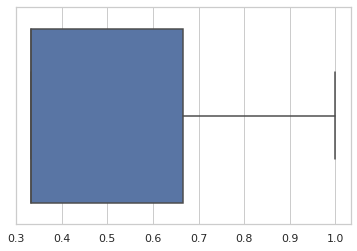

In [31]:
sns.set_theme(style="whitegrid")

ax = sns.boxplot(x=k_precision)

In [32]:
zero_cnt = list(filter(lambda k: k==0.0, k_precision))
print(len(zero_cnt))
print(len(k_precision))

0
63


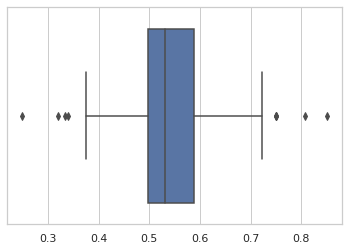

In [33]:
ax = sns.boxplot(x=prediction_metrics['precision'])

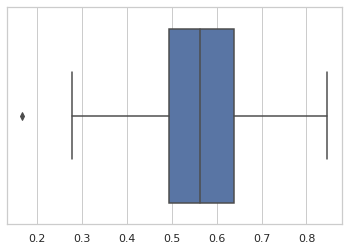

In [34]:
ax = sns.boxplot(x=prediction_metrics['recall'])

In [35]:
np.mean(clz_report_lst['precision'])

0.23740180375281522

In [36]:
np.mean(clz_report_lst['recall'])

0.6720645726207654

In [57]:
problematic = []
for _source, _precision_clazz, _recall_clazz in zip(source_lst, prediction_metrics['precision'], prediction_metrics['recall']):
    if _precision_clazz <= 0.4:
        problematic.append(_source)

In [58]:
sorted(problematic)


['https://github.com/google/ExoPlayer/issues/8387',
 'https://medium.com/@JasonCromer/android-asynctask-http-request-tutorial-6b429d833e28',
 'https://stackoverflow.com/questions/37096547',
 'https://stackoverflow.com/questions/40168601',
 'https://stackoverflow.com/questions/6442054']

In [50]:
import scipy

result = scipy.stats.mannwhitneyu(
    prediction_metrics['precision'], 
    random_prediction_metrics['precision'], 
    alternative='two-sided'
)


logger.info("Comparing to a random guesser...\n")
logger.info(Fore.YELLOW + "Mann-whitney-U" + Style.RESET_ALL)
logger.info("stats: {:.2f}".format(result.statistic))
logger.info("p-value: {:.2f}".format(result.pvalue))
logger.info(
    '\n\nIf the p-value is below the usually agreed alpha, the null hypothesis can be rejected and at least one significant difference can be assumed...')

Comparing to a random guesser...

Mann-whitney-U
stats: 7780.50
p-value: 0.00


If the p-value is below the usually agreed alpha, the null hypothesis can be rejected and at least one significant difference can be assumed...


In [51]:
from numpy import mean
from numpy import var
from math import sqrt

def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

logger.info(Fore.YELLOW + "Effect-size" + Style.RESET_ALL)
logger.info("Cohen's D: {:.2f}".format(
    cohend(prediction_metrics['precision'], random_prediction_metrics['precision']))
)


Effect-size
Cohen's D: 0.60
